# RFM Analysis of Retail Customers

In [16]:
!pip install squarify

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify
from datetime import datetime

In [18]:
# Changing our current working directory to match the project file in my pc
os.getcwd()
os.chdir("D:\Projects\RFM Analysis\CSV Files")

In [19]:
# Importing the csv files into separate data frames
df = pd.read_csv('online_retail0910.csv')
df1 = pd.read_csv('online_retail1011.csv')

## Data Preprocessing

In [20]:
# Checking our data types for each column in our data frames to make sure they are readable by
#our language packs.
# InvoiceDate is an object type that must be converted to datetime.
df1.dtypes

Invoice          int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID      int64
Country         object
dtype: object

In [21]:
#Setting our InvoiceDate column to a datetime64 data type and Invoice to a Object data type for 2009-2010 df
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['Invoice'] = df['Invoice'].astype('object')

#Setting our InvoiceDate column to a datetime64 data type and Invoice to a Object data type for 2010-2011
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format='%m/%d/%Y %H:%M')
df1['Invoice'] = df1['Invoice'].astype('object')

# RFM Analysis

### 2009-2010 Data Frame

### Summary Statistics and Outliers

In [22]:
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns].describe([0.01, 0.05, 0.10, 0.20,0.50,0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,20%,50%,75%,90%,95%,99%,max
Quantity,407664.0,13.585585,96.840747,1.000,1.00,1.00,1.00,2.00,5.00,12.00,24.00,36.0,144.00,19152.0
Price,407664.0,3.294438,34.757965,0.001,0.29,0.42,0.65,0.85,1.95,3.75,6.75,8.5,14.95,10953.5
Customer ID,407664.0,15368.592598,1679.762138,12346.000,12435.00,12731.00,13044.00,13635.00,15321.00,16812.00,17706.00,17913.0,18196.00,18287.0


### Recency and Frequency Scoring

In [23]:
# Setting the latest date in the InvoiceDate column and assigning it to a variable
latest_date = df['InvoiceDate'].max()

# Setting the reference date as one day after the latest invoice date.
# The recency metric is a measure of how many days have elapsed since the customer's last transaction. 
# By setting the reference date to one day after the last transaction in the data, 
#we ensure that the most recent transaction has a recency of at least one day.
reference_date = latest_date + pd.Timedelta(days=1)

# Calculate Recency for each transaction as the number of days from the reference date
df['Recency'] = (reference_date - df['InvoiceDate']).dt.days

# Group by Customer ID to calculate the minimum Recency and Frequency
rfm_df = df.groupby('Customer ID').agg({
    'Recency': 'min',
    'Invoice': 'count'
}).rename(columns={'Invoice': 'Frequency'})

# Assign Recency and Frequency scores using quintiles
# The labels are reversed for Recency because a lower Recency is better (more recent)
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
# Higher frequency is better, so the labels are not reversed
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Defining the segmentation map
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# Function to assign segments based on the segmentation map.
def assign_segment(row):
    # Concatenate RecencyScore and FrequencyScore to a string.
    score_str = f"{row['RecencyScore']}{row['FrequencyScore']}"
    for pattern, segment in seg_map.items():
        if re.match(pattern, score_str):
            return segment

# Apply the function to the RFM data frame to create the 'Segment' column.
rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)


# First, calculate the total Monetary value for each customer.
monetary_df = df.groupby('Customer ID')['Price'].sum().reset_index()
monetary_df.rename(columns={'Price': 'Monetary'}, inplace=True)

# Merge this with your existing rfm_df to add the Monetary column.
rfm_df = pd.merge(rfm_df, monetary_df, on='Customer ID', how='left')

# Assigning Monetary scores using quintiles (1-5 scoring).
# The labels are not reversed for Monetary (unlike recency) because a higher monetary value is better.
rfm_df['MonetaryScore'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Combining our RFM scores into their own str column, R / F / M
rfm_df["RFMScore"] = (rfm_df['RecencyScore'].astype(str) +
                      rfm_df['FrequencyScore'].astype(str) +
                      rfm_df['MonetaryScore'].astype(str))

rfm_df


,Customer ID,Recency,Frequency,RecencyScore,FrequencyScore,Segment,Monetary,MonetaryScore,RFMScore
0,12346,165,33,2,3,At Risk,206.36,4,234
1,12347,3,71,5,4,Champions,162.95,3,543
2,12348,74,20,2,2,Hibernating,14.39,1,221
3,12349,43,102,3,4,Loyal Customers,875.34,5,345
4,12351,11,21,5,2,Potential Loyalists,49.46,2,522
...,...,...,...,...,...,...,...,...,...
4307,18283,18,230,4,5,Loyal Customers,498.82,5,455
4308,18284,67,28,3,2,About to Sleep,91.09,2,322
4309,18285,296,12,1,1,Hibernating,100.20,3,113
4310,18286,112,67,2,4,At Risk,286.30,4,244


### 2010-2011 Data Frame

### Summary Statistics and Outliers

In [24]:
numeric_columns1 = df1.select_dtypes(include=['number']).columns
df1[numeric_columns1].describe([0.01, 0.05, 0.10, 0.20, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,20%,50%,90%,95%,99%,max
Quantity,397885.0,12.988208,179.331551,1.000,1.00,1.00,1.00,2.00,6.00,24.00,36.0,120.00,80995.00
Price,397885.0,3.116525,22.097861,0.001,0.21,0.42,0.55,0.85,1.95,6.35,8.5,14.95,8142.75
Customer ID,397885.0,15294.416882,1713.144421,12346.000,12415.00,12627.00,12883.00,13552.00,15159.00,17725.00,17912.0,18211.00,18287.00


### Recency and Frequency Scoring

In [25]:
# Finding the latest date in the InvoiceDate column and assign it to a variable.
latest_date = df1['InvoiceDate'].max()

# Set the reference date as one day after the latest invoice date.
# The recency metric is a measure of how many days have elapsed since the customer's last transaction. 
# By setting the reference date to one day after the last transaction in the data, 
#we ensure that the most recent transaction has a recency of at least one day.
reference_date = latest_date + pd.Timedelta(days=1)

# Calculate Recency for each transaction as the number of days from the reference date.
df1['Recency'] = (reference_date - df1['InvoiceDate']).dt.days

# Group by Customer ID to calculate the minimum Recency and Frequency.
rfm_df1 = df1.groupby('Customer ID').agg({
    'Recency': 'min',
    'Invoice': 'count'
}).rename(columns={'Invoice': 'Frequency'})

# Assign Recency and Frequency scores using quintiles.
# The labels are reversed for Recency because a lower Recency numerical amount
#is better (more recent).
rfm_df1['RecencyScore'] = pd.qcut(rfm_df1['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# Higher frequency is better, so the labels are not reversed.
rfm_df1['FrequencyScore'] = pd.qcut(rfm_df1['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Defining the segmentation map.
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# Function to assign segments based on the segmentation map.
def assign_segment(row):
    # Concatenate RecencyScore and FrequencyScore to a string.
    score_str = f"{row['RecencyScore']}{row['FrequencyScore']}"
    for pattern, segment in seg_map.items():
        if re.match(pattern, score_str):
            return segment

# Apply the function to the RFM DataFrame to create the 'Segment' column.
rfm_df1['Segment'] = rfm_df1.apply(assign_segment, axis=1)

# Assuming you have a 'Price' column in the original df that represents the monetary value of each purchase.
# First, calculate the total Monetary value for each customer.
monetary_df = df1.groupby('Customer ID')['Price'].sum().reset_index()
monetary_df.rename(columns={'Price': 'Monetary'}, inplace=True)

# Merge this with your existing rfm_df1 to add the Monetary column.
rfm_df1 = pd.merge(rfm_df1, monetary_df, on='Customer ID', how='left')

# Assigning Monetary scores using quintiles (1-5 scoring).
# The labels are not reversed for Monetary (unlike recency) because a higher monetary value is better.
rfm_df1['MonetaryScore'] = pd.qcut(rfm_df1['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Combining our RFM scores into there own str column, R / F / M.
rfm_df1["RFMScore"] = (rfm_df1['RecencyScore'].astype(str) +
                       rfm_df1['FrequencyScore'].astype(str)+
                       rfm_df1['MonetaryScore'].astype(str))

In [26]:
rfm_df1

,Customer ID,Recency,Frequency,RecencyScore,FrequencyScore,Segment,Monetary,MonetaryScore,RFMScore
0,12346,326,1,1,1,Hibernating,1.04,1,111
1,12347,2,182,5,5,Champions,481.21,5,555
2,12348,75,31,2,3,At Risk,178.71,4,234
3,12349,19,73,4,4,Loyal Customers,605.10,5,445
4,12350,310,17,1,2,Hibernating,65.30,2,122
...,...,...,...,...,...,...,...,...,...
4333,18280,278,10,1,1,Hibernating,47.65,2,112
4334,18281,181,7,1,1,Hibernating,39.36,1,111
4335,18282,8,12,5,1,New Customers,62.39,2,512
4336,18283,4,756,5,5,Champions,1220.93,5,555


## Visualization of Results
### 2009-2010 Data Frame

In [27]:
rfmstats = rfm_df[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "median", "count", "std"])
rfmstats.columns = rfmstats.columns.map('_'.join).str.strip('|')

In [28]:
rfmstats

,Recency_mean,Recency_median,Recency_count,Recency_std,Frequency_mean,Frequency_median,Frequency_count,Frequency_std,Monetary_mean,Monetary_median,Monetary_count,Monetary_std
Segment,,,,,,,,,,,,
About to Sleep,53.510386,53.0,337,10.075048,15.777448,16.0,337,8.254564,72.173739,48.350,337,327.712404
At Risk,166.143328,147.0,607,80.323156,58.200988,50.0,607,23.452694,206.508934,156.760,607,551.082102
Can't Lose,128.868687,109.0,99,51.635624,220.646465,180.0,99,152.359826,723.553949,579.630,99,719.263805
Champions,7.054945,7.0,637,4.540364,271.662480,158.0,637,430.094963,870.167650,508.510,637,1824.554456
Hibernating,206.629890,201.0,997,89.623154,13.987964,13.0,997,8.591689,85.595548,42.270,997,576.778366
Loyal Customers,37.392258,33.0,775,16.261698,167.990968,120.0,775,148.140598,501.896188,360.020,775,419.709951
Need Attention,53.755814,53.0,172,10.359543,44.639535,43.5,172,7.960300,144.616512,128.305,172,80.551758
New Customers,7.825397,8.0,63,4.346076,7.476190,7.0,63,3.999424,33.819524,22.000,63,42.407214
Potential Loyalists,18.499037,18.0,519,9.708468,36.537572,35.0,519,13.351140,120.870096,111.050,519,68.328284


In [29]:
rfm_df

,Customer ID,Recency,Frequency,RecencyScore,FrequencyScore,Segment,Monetary,MonetaryScore,RFMScore
0,12346,165,33,2,3,At Risk,206.36,4,234
1,12347,3,71,5,4,Champions,162.95,3,543
2,12348,74,20,2,2,Hibernating,14.39,1,221
3,12349,43,102,3,4,Loyal Customers,875.34,5,345
4,12351,11,21,5,2,Potential Loyalists,49.46,2,522
...,...,...,...,...,...,...,...,...,...
4307,18283,18,230,4,5,Loyal Customers,498.82,5,455
4308,18284,67,28,3,2,About to Sleep,91.09,2,322
4309,18285,296,12,1,1,Hibernating,100.20,3,113
4310,18286,112,67,2,4,At Risk,286.30,4,244


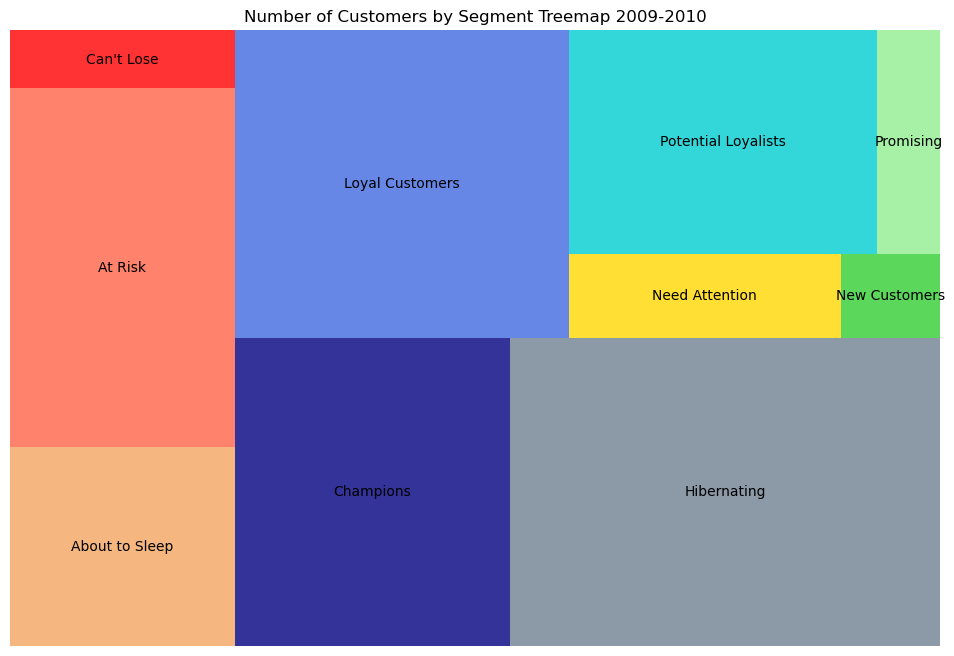

In [30]:
# Define a color map for each segment in or segmentation map
color_map = {
    'Hibernating': 'slategrey',
    'At Risk': 'tomato',
    'Can\'t Lose': 'red',
    'About to Sleep': 'sandybrown',
    'Need Attention': 'gold',
    'Loyal Customers': 'royalblue',
    'Promising': 'lightgreen',
    'New Customers': 'limegreen',
    'Potential Loyalists': 'darkturquoise',
    'Champions': 'navy'
}

# Calculating the count of customers in each segment
segment_counts = rfm_df.groupby('Segment').size().reset_index(name='counts')

# Assigning colors based on the defined color map
colors = [color_map[segment] for segment in segment_counts['Segment']]

# Normalize sizes of the treemap.
sizes = segment_counts['counts'].values
normed_sizes = sizes / sizes.max()

# Plotting our Segmentation map into a treemap.
plt.figure(figsize=(12, 8))
squarify.plot(sizes=normed_sizes, label=segment_counts['Segment'], alpha=0.8, color=colors)
plt.title('Number of Customers by Segment Treemap 2009-2010')
plt.axis('off')
plt.show()

### 2010-2011 Data Frame

In [31]:
rfmstats1 = rfm_df1[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "median", "count", "std"])
rfmstats1.columns = rfmstats1.columns.map('_'.join).str.strip('|')

In [32]:
rfmstats1

,Recency_mean,Recency_median,Recency_count,Recency_std,Frequency_mean,Frequency_median,Frequency_count,Frequency_std,Monetary_mean,Monetary_median,Monetary_count,Monetary_std
Segment,,,,,,,,,,,,
About to Sleep,53.838006,53.0,321,11.175528,15.682243,15.0,321,7.907984,61.588692,43.97,321,115.924765
At Risk,167.373702,145.0,578,82.640577,56.112457,50.0,578,22.846397,176.464204,153.12,578,113.487170
Can't Lose,146.271605,123.0,81,73.957422,182.296296,156.0,81,71.866272,575.915938,474.07,81,389.124036
Champions,5.915980,5.0,607,3.754143,288.617792,166.0,607,535.814129,849.647414,479.40,607,2052.449775
Hibernating,211.391802,212.0,1049,89.201526,13.387989,13.0,1049,8.021743,55.494559,39.60,1049,91.280972
Loyal Customers,34.033857,30.0,827,15.834077,156.350665,116.0,827,121.060969,496.120351,332.93,827,719.957203
Need Attention,52.652174,53.0,207,11.349042,41.434783,40.0,207,8.379607,126.531932,118.21,207,53.886313
New Customers,6.709091,8.0,55,3.303605,7.345455,8.0,55,3.864454,28.450364,19.15,55,30.073273
Potential Loyalists,16.462451,17.0,506,9.371305,34.318182,33.0,506,12.684892,111.604389,96.17,506,74.070153


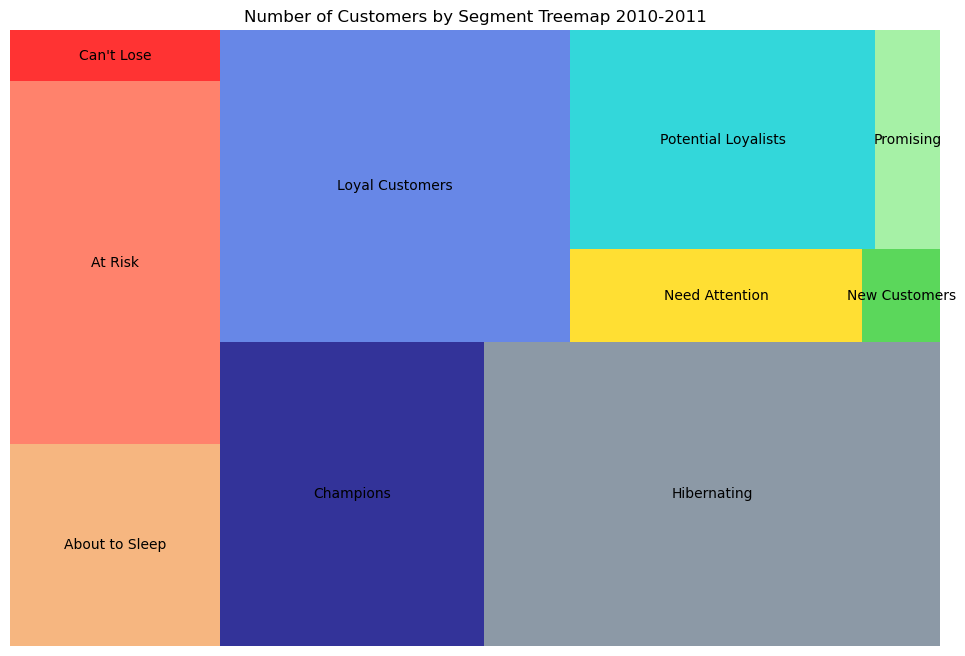

In [33]:
# First, calculate the count of customers in each segment
segment_counts1 = rfm_df1.groupby('Segment').size().reset_index(name='counts')

# Assigning colors based on the defined color map, in the previous code cell.
colors = [color_map[segment] for segment in segment_counts1['Segment']]

# Normalize sizes of the treemap.
sizes = segment_counts1['counts'].values
normed_sizes = sizes / sizes.max()

# Plotting our Segmentation map into a treemap.
plt.figure(figsize=(12, 8))
squarify.plot(sizes=normed_sizes, label=segment_counts1['Segment'], alpha=0.8, color=colors)
plt.title('Number of Customers by Segment Treemap 2010-2011')
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

In [34]:
#Exporting our RFM data frames in an excel file to be furth analyzed in SQL and Tableau
rfm_df.to_excel('rfm_df.xlsx')
rfm_df1.to_excel('rfm_df1.xlsx')